# Titanic from scratch

Looking at the [titanic](https://www.kaggle.com/competitions/titanic) kaggle competition without a high level framework, building a linear model or NN from scratch.

## Data

In [1]:
import pandas as pd
import numpy as np

train_frames = pd.read_csv("data/titanic/train.csv")
test_frames = pd.read_csv("data/titanic/test.csv")

train_frames.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# Clean the data (age, cabin and embarked all have NA fields on some rows)
# Replace NA with mode
# Could do a lot better here, eg. Predict a persons age based on other fields

for frames in [train_frames, test_frames]:
    modes = frames.mode().iloc[0]  # Mode returns multiple if there is a "tie" for the mode
    frames.fillna(modes, inplace=True)

train_frames.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S


In [3]:
train_frames.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

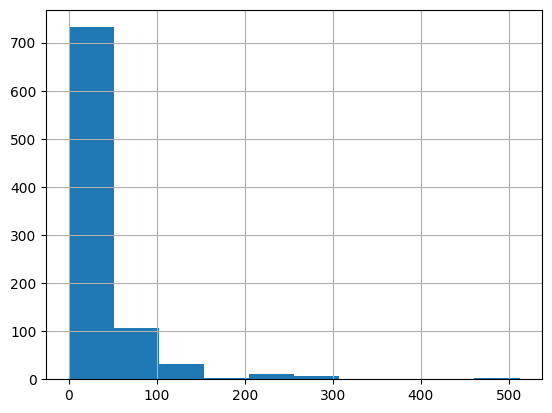

In [4]:
# Fare looks like its a distribution with a long tail - yup
# Lots of models dont like this (linear, NNs)
train_frames["Fare"].hist()

<Axes: >

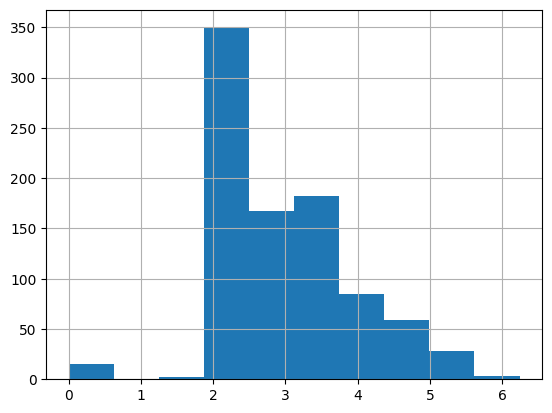

In [5]:
# Lets take the log and use that instead
for frames in [train_frames, test_frames]:
    frames["LogFare"] = np.log(frames["Fare"] + 1)

# Thats better
train_frames["LogFare"].hist()

In [6]:
pass_classes = sorted(train_frames.Pclass.unique())
pass_classes

[1, 2, 3]

In [7]:
# We have some fields that are text fields but really categories, lets add dummy fields to represent them as 0 or 1

cat_columns = ["Sex", "Pclass", "Embarked"]
train_frames = pd.get_dummies(train_frames, columns=cat_columns)
test_frames = pd.get_dummies(test_frames, columns=cat_columns)

added_cols = ["Sex_male", "Sex_female", "Pclass_1", "Pclass_2", "Pclass_3", "Embarked_C", "Embarked_Q", "Embarked_S"]
train_frames.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B96 B98,2.110213,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,4.280593,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,2.188856,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,3.990834,1,0,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,2.202765,0,1,0,0,1,0,0,1


## Tensors

In [8]:
import torch as torch
from torch import tensor

# Our dependent variable as a tensor (the thing we are trying to predict)
t_dep = tensor(train_frames.Survived)

In [9]:
# Our independent variables (the things we are using to predict) as tensors

indep_cols = ["Age", "SibSp", "Parch", "LogFare"] + added_cols
t_indep = tensor(train_frames[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.,  1.,  0.,  ...,  0.,  0.,  1.],
        [38.,  1.,  0.,  ...,  1.,  0.,  0.],
        [26.,  0.,  0.,  ...,  0.,  0.,  1.],
        ...,
        [24.,  1.,  2.,  ...,  0.,  0.,  1.],
        [26.,  0.,  0.,  ...,  1.,  0.,  0.],
        [32.,  0.,  0.,  ...,  0.,  1.,  0.]])

In [10]:
# Could think of as [rows, cols] in shape
t_indep.shape

torch.Size([891, 12])

In [11]:
# Rank is 2 (number of dimensions)
len(t_indep.shape)

2

## Linear model

In [12]:
# Need a random coefficient for each col to start
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff) - 0.5  # Between 0 and 1 so subtract to center them
coeffs

tensor([-0.1656,  0.4879, -0.0474, -0.1022,  0.4094, -0.1653, -0.4085, -0.0567,
        -0.0100,  0.3638, -0.4654,  0.1737])

In [13]:
# We're going to multiply each row by the coefficients like this (using broadcasting)
t_indep * coeffs

tensor([[-3.6436,  0.4879, -0.0000,  ...,  0.0000, -0.0000,  0.1737],
        [-6.2935,  0.4879, -0.0000,  ...,  0.3638, -0.0000,  0.0000],
        [-4.3061,  0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.1737],
        ...,
        [-3.9748,  0.4879, -0.0947,  ...,  0.0000, -0.0000,  0.1737],
        [-4.3061,  0.0000, -0.0000,  ...,  0.3638, -0.0000,  0.0000],
        [-5.2998,  0.0000, -0.0000,  ...,  0.0000, -0.4654,  0.0000]])

In [14]:
# One problem is that when we sum these up the first column (Age) is going to dominate things
# Lets make everything between 0 and 1 to prevent things like that
vals, indices = t_indep.max(dim=0)
t_indep = t_indep / vals

# This looks better now
t_indep * coeffs

tensor([[-0.0455,  0.0610, -0.0000,  ...,  0.0000, -0.0000,  0.1737],
        [-0.0787,  0.0610, -0.0000,  ...,  0.3638, -0.0000,  0.0000],
        [-0.0538,  0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.1737],
        ...,
        [-0.0497,  0.0610, -0.0158,  ...,  0.0000, -0.0000,  0.1737],
        [-0.0538,  0.0000, -0.0000,  ...,  0.3638, -0.0000,  0.0000],
        [-0.0662,  0.0000, -0.0000,  ...,  0.0000, -0.4654,  0.0000]])

In [15]:
# Lets make a prediction
preds = (t_indep * coeffs).sum(axis=1)
preds[:20]

tensor([ 0.5541, -0.2978, -0.0912, -0.4769,  0.4647, -0.1524, -0.0021,  0.6934,
        -0.1141,  0.1176, -0.0037, -0.5744,  0.4957,  0.4571, -0.0662, -0.2085,
         0.1102,  0.4336, -0.0529,  0.1043])

In [16]:
# That works bit isn't much use with random coefficients, time for gradient descent

# We need a loss function, lets take the average error of the rows (abs val of the diff between prediction and dependent)
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.6514)

In [17]:
# Lets shove predictions and loss into some functions


def calc_preds(coeffs, indeps):
    return (indeps * coeffs).sum(axis=1)


def calc_loss(preds, deps):
    return torch.abs(preds - deps).mean()

### Single gradient descent step

In [18]:
# We want the pytorch to calculate the derivatives for the coefficients for us
coeffs.requires_grad_()

tensor([-0.1656,  0.4879, -0.0474, -0.1022,  0.4094, -0.1653, -0.4085, -0.0567,
        -0.0100,  0.3638, -0.4654,  0.1737], requires_grad=True)

In [19]:
# Now we get a gradient function for the loss
preds = calc_preds(coeffs, t_indep)
loss = calc_loss(preds, t_dep)
loss

tensor(0.6514, grad_fn=<MeanBackward0>)

In [20]:
loss.backward()
coeffs.grad

tensor([ 0.0022,  0.0115, -0.0168, -0.0361,  0.3042, -0.2941, -0.0943, -0.0045,
         0.1089, -0.0224, -0.0774,  0.1100])

In [21]:
# Lets  tweak the coeffs and see what happens

lr = 0.1
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    preds = calc_preds(coeffs, t_indep)
    loss = calc_loss(preds, t_dep)

# Hurray, run this multiple times and we are gradient descending
loss

tensor(0.6297)

### Training the linear model

In [41]:
# We need to split the training data to get validation
from fastai.data.transforms import RandomSplitter

# List of the indexes of the rows for each split
trn_split, val_split = RandomSplitter()(train_frames)

# So lets create them
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_indep), len(val_indep)

(713, 178)

In [42]:
# We'll need our coefficient update in a function


def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)


# And a run of a single training epoch
def one_epoch(coeffs, lr):
    preds = calc_preds(coeffs, t_indep)
    loss = calc_loss(preds, t_dep)

    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)

    print(f"Epoch loss: {loss}")


# A function to initialise coeffs
def init_coeffs():
    return (torch.rand(n_coeff) - 0.5).requires_grad_()


# And now the function to run it all
def train_model(epochs=30, lr=0.01):
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs, lr)

    return coeffs

In [54]:
# Lets run it - it kind works!
coeffs = train_model()

Epoch loss: 0.5546775460243225
Epoch loss: 0.5486955642700195
Epoch loss: 0.5382088422775269
Epoch loss: 0.5272627472877502
Epoch loss: 0.5216339230537415
Epoch loss: 0.5174338221549988
Epoch loss: 0.5122694373130798
Epoch loss: 0.5062087178230286
Epoch loss: 0.4991477429866791
Epoch loss: 0.49082162976264954
Epoch loss: 0.4813975691795349
Epoch loss: 0.4708353281021118
Epoch loss: 0.45880991220474243
Epoch loss: 0.4449731707572937
Epoch loss: 0.4293661117553711
Epoch loss: 0.4122144877910614
Epoch loss: 0.3936729431152344
Epoch loss: 0.3758898973464966
Epoch loss: 0.36661872267723083
Epoch loss: 0.3601922392845154
Epoch loss: 0.35384601354599
Epoch loss: 0.3472423851490021
Epoch loss: 0.343229204416275
Epoch loss: 0.3428097665309906
Epoch loss: 0.34579071402549744
Epoch loss: 0.34940654039382935
Epoch loss: 0.3544391691684723
Epoch loss: 0.36629730463027954
Epoch loss: 0.3824806213378906
Epoch loss: 0.39783573150634766


In [55]:
# Lets see what coefficeints we ended up with
def show_coeffs():
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))


show_coeffs()

{'Age': tensor(0.4231),
 'SibSp': tensor(-0.1346),
 'Parch': tensor(0.0664),
 'LogFare': tensor(0.6440),
 'Sex_male': tensor(-0.5410),
 'Sex_female': tensor(0.2186),
 'Pclass_1': tensor(0.3794),
 'Pclass_2': tensor(0.3629),
 'Pclass_3': tensor(-0.1153),
 'Embarked_C': tensor(0.3382),
 'Embarked_Q': tensor(-0.0491),
 'Embarked_S': tensor(0.3029)}

### Measuring accuracy

In [56]:
# The kaggle competition is judging us on accuracy (proportion of rows where we got the answer correct)
# of predictions not on loss, so lets calculate that

preds = calc_preds(coeffs, val_indep)

# Lets have >0.5 == survive
results = val_dep.bool() == (preds > 0.5)

In [57]:
# Shove it in a function for the future
def accuracy(coeffs):
    preds = calc_preds(coeffs, val_indep)
    results = val_dep.bool() == (preds > 0.5)
    return results.float().mean()


accuracy(coeffs)

tensor(0.6180)

### Using sigmoid

In [58]:
# Note that sometimes we predict >1 or <0 for survival which doesnt make much sense
preds[:20]

tensor([ 1.5000e+00,  1.4704e+00,  8.3182e-01,  3.6436e-02,  5.1877e-01,
         7.7986e-01,  5.2935e-01,  7.9328e-03,  2.6279e-02,  8.2176e-01,
         1.6456e+00,  1.5143e+00,  4.0499e-01, -3.4661e-01,  5.7262e-04,
         7.5968e-01,  6.6836e-01,  7.2556e-01, -4.7297e-02,  3.8006e-01])

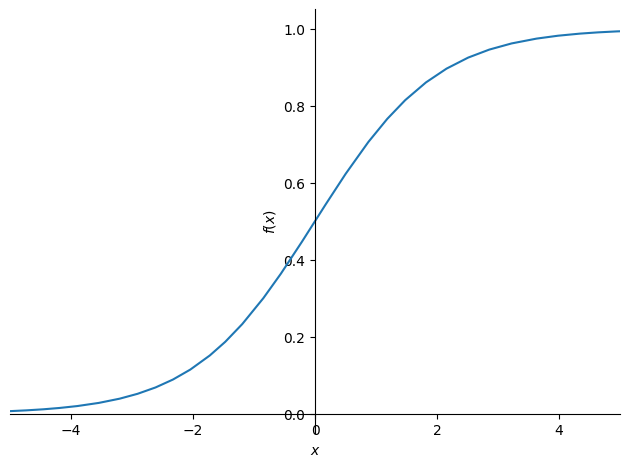

In [59]:
# If we can make our preds 0 to 1 it makes things easier to optimise for and might improve the results
# We can run our preds through the sigmoid function, it looks like this

import sympy

sympy.plot("1/(1+exp(-x))", xlim=(-5, 5));

In [62]:
# This is build into pytorch so lets redefine cal_preds


def calc_preds(coeffs, indeps):
    return torch.sigmoid((indeps * coeffs).sum(axis=1))


# Lets see how our training does now
coeffs = train_model(lr=100)
accuracy(coeffs)

Epoch loss: 0.5009738206863403
Epoch loss: 0.32492631673812866
Epoch loss: 0.32393795251846313
Epoch loss: 0.32182762026786804
Epoch loss: 0.30690449476242065
Epoch loss: 0.2758479118347168
Epoch loss: 0.26962998509407043
Epoch loss: 0.2395869642496109
Epoch loss: 0.21339288353919983
Epoch loss: 0.21312007308006287
Epoch loss: 0.21239015460014343
Epoch loss: 0.20967155694961548
Epoch loss: 0.2066357135772705
Epoch loss: 0.20470397174358368
Epoch loss: 0.20498500764369965
Epoch loss: 0.20533636212348938
Epoch loss: 0.20536118745803833
Epoch loss: 0.2052973210811615
Epoch loss: 0.20503248274326324
Epoch loss: 0.20401735603809357
Epoch loss: 0.20045343041419983
Epoch loss: 0.19081436097621918
Epoch loss: 0.18857799470424652
Epoch loss: 0.18855270743370056
Epoch loss: 0.18855218589305878
Epoch loss: 0.18855218589305878
Epoch loss: 0.18855218589305878
Epoch loss: 0.18855218589305878
Epoch loss: 0.18855218589305878
Epoch loss: 0.18855218589305878


tensor(0.8090)

Generally speaking if you are wondering why your model with a binary dependent variable isnt
training very well, chuck it through a sigmoid

In [64]:
show_coeffs()

{'Age': tensor(-30.0348),
 'SibSp': tensor(-7.6965),
 'Parch': tensor(5.9681),
 'LogFare': tensor(18.6204),
 'Sex_male': tensor(-297.2229),
 'Sex_female': tensor(234.7081),
 'Pclass_1': tensor(101.6380),
 'Pclass_2': tensor(31.6891),
 'Pclass_3': tensor(-194.9632),
 'Embarked_C': tensor(25.9663),
 'Embarked_Q': tensor(-4.4031),
 'Embarked_S': tensor(-84.0325)}